# 1. Importing Required Libraries

In [41]:
import warnings
warnings.simplefilter('ignore')

import nltk
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kalyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Data Ingestion

In [3]:
df = pd.read_csv('spam.csv', encoding='latin1')

# 3. Exploratory Data Analysis

In [4]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [5]:
df.shape

(5572, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [8]:
df.rename(columns={'v1':'Target','v2':'Message'},inplace=True)

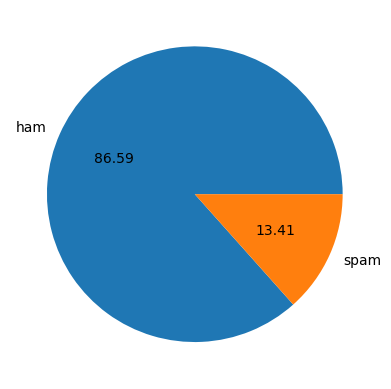

In [9]:
plt.pie(df['Target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

# 4. Data Pre-processing

### 4.1 Handling Missing Values

In [10]:
df = df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])

### 4.2 Handling Duplicate Records

In [11]:
df.duplicated().sum()

403

In [12]:
df = df.drop_duplicates(keep='first')

In [13]:
df.shape

(5169, 2)

### 4.3 Label Encoding

In [14]:
encoder = LabelEncoder()
df['Target'] = encoder.fit_transform(df['Target'])

### 4.4 Text Preprocessing

In [15]:
stemmer = PorterStemmer()

In [16]:
def transform_text(text):
    text = nltk.word_tokenize(text.lower())
    text = [stemmer.stem(word) for word in text if word.isalnum()]
    text = [word for word in text if word not in stop_words and word not in string.punctuation]

    return " ".join(text)

In [17]:
df['Transformed_Text'] = df['Message'].apply(transform_text)

In [18]:
df

,Target,Message,Transformed_Text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail onli bugi n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,thi 2nd time tri 2 contact u pound prize 2 cla...
5568,0,Will Ì_ b going to esplanade fr home?,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",piti wa mood ani suggest
5570,0,The guy did some bitching but I acted like i'd...,guy bitch act like interest buy someth els nex...


### 4.5 Feature Engineering

In [46]:
preprocessor = TfidfVectorizer(max_features=3000)

In [47]:
df['Transformed_Text'] = preprocessor.fit_transform(df['Transformed_Text']).toarray()

### 4.6 Training and Testing Data Preparation

In [36]:
x = df['Transformed_Text'] 
y = df['Target'].values

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

In [38]:
print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5169,) (5169,)
(4135, 3000) (4135,)
(1034, 3000) (1034,)


# 5. Modelling

### 5.1 Model Training

In [33]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XG Boost': XGBClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier()
}

In [42]:
model_list = []
train_accuracy_list = []
test_accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_test)
    
    train_accuracy = accuracy_score(y_train,y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Training Accuracy: ",train_accuracy)
    print("Testing Accuracy: ", test_accuracy)
    print("Precision: ",precision)
    print("Recall: ",recall)
    print("F1 Score: ",f1)


    model_list.append(model_name)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print("=" * 35)

max_accuracy_index = test_accuracy_list.index(max(test_accuracy_list))
print(f"\nThe best model based on accuracy is {model_list[max_accuracy_index]} with Testing Accuracy: {test_accuracy_list[max_accuracy_index]}")

Model: Logistic Regression
Training Accuracy:  0.966142684401451
Testing Accuracy:  0.9564796905222437
Precision:  0.979381443298969
Recall:  0.6884057971014492
F1 Score:  0.8085106382978723
Model: Decision Tree
Training Accuracy:  0.999758162031439
Testing Accuracy:  0.9497098646034816
Precision:  0.8161764705882353
Recall:  0.8043478260869565
F1 Score:  0.8102189781021898
Model: Random Forest
Training Accuracy:  0.999758162031439
Testing Accuracy:  0.9738878143133463
Precision:  0.9743589743589743
Recall:  0.8260869565217391
F1 Score:  0.8941176470588236
Model: Support Vector Machine
Training Accuracy:  0.9963724304715841
Testing Accuracy:  0.9738878143133463
Precision:  0.9826086956521739
Recall:  0.8188405797101449
F1 Score:  0.8932806324110671
Model: Naive Bayes
Training Accuracy:  0.8909310761789601
Testing Accuracy:  0.8713733075435203
Precision:  0.511520737327189
Recall:  0.8043478260869565
F1 Score:  0.6253521126760564
Model: Gradient Boosting
Training Accuracy:  0.9772672309

In [43]:
results = {
    'Model': model_list,
    'Train Accuracy': train_accuracy_list,
    'Test Accuracy': test_accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
}

results = pd.DataFrame(results).sort_values(by=['Test Accuracy', 'Recall'], ascending=False)
results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
7,Extra Trees Classifier,0.999758,0.977756,0.975207,0.855072,0.911197
2,Random Forest,0.999758,0.973888,0.974359,0.826087,0.894118
3,Support Vector Machine,0.996372,0.973888,0.982609,0.818841,0.893281
6,XG Boost,0.989117,0.969052,0.941667,0.818841,0.875969
5,Gradient Boosting,0.977267,0.956480,0.926606,0.731884,0.817814
0,Logistic Regression,0.966143,0.956480,0.979381,0.688406,0.808511
1,Decision Tree,0.999758,0.949710,0.816176,0.804348,0.810219
4,Naive Bayes,0.890931,0.871373,0.511521,0.804348,0.625352


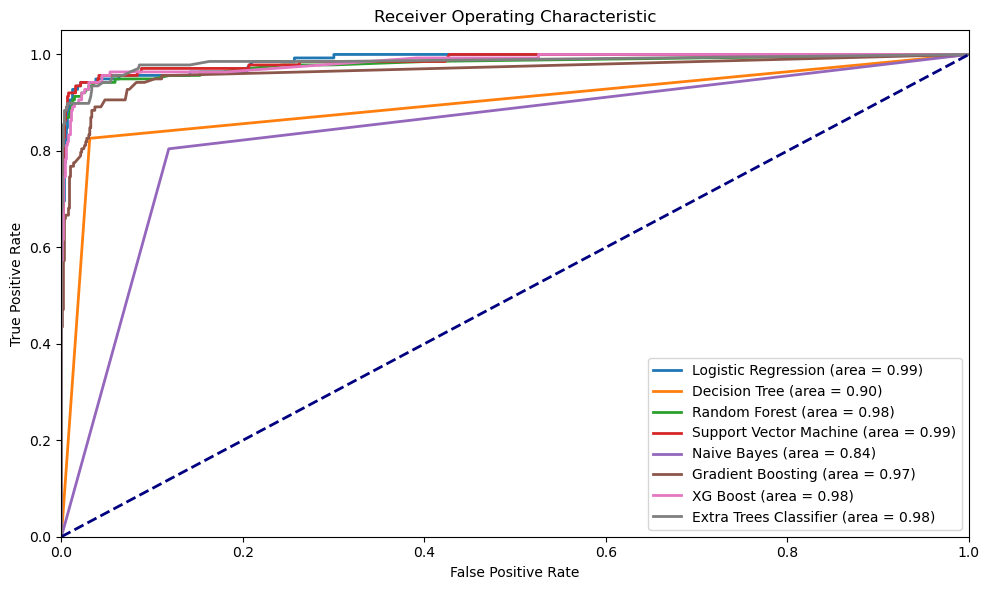

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model in models.items():
    y_score = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = roc_auc_score(y_test, y_score)
    ax.plot(fpr, tpr, lw=2, label='%s (area = %0.2f)' % (model_name, roc_auc))

ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [51]:
best_model_name = model_list[max_accuracy_index]
best_model = models[best_model_name]

pickle.dump(preprocessor,open('Spam_Preprocessor.pkl','wb'))
pickle.dump(best_model,open('Spam_Model.pkl','wb'))